In [1]:
!pip install pyLDAvis

In [2]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=528fcf04349a3d4bd78fde4b1f19efa1e8cf6f105f983e16f1d484e4ed7c871d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
!pip install bertopic

  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/f8/26/ca0f1bb049b83c25cafa39f3fa5287c826a6ab36e665c906209e07f4deac/Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 13.5 MB/s eta 0:00:00
Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manyl

In [108]:
pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [109]:
import os
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
#import pyLDAvis.gensim_models
import langid
import random

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import hdbscan
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

In [5]:
df = pd.read_csv("/kaggle/input/kyivchannels/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [6]:
df.head()

,channelname,Date,content,lang
0,kyivpolitics,2023-08-01 09:45:38,Отбой. Угрозы для столицы нет\n\nКиев. Главное...,ru
1,kyivpolitics,2023-08-01 10:03:38,На 8 перекрестках Киева в пилотном режиме внед...,ru
2,kyivpolitics,2023-08-01 14:42:31,⚡️НБУ отозвал банковскую лицензию Конкорд Банк...,ru
3,kyivpolitics,2023-08-01 15:37:34,Завтра синоптики прогнозируют небольшой дождь ...,ru
4,kyivpolitics,2023-08-01 13:06:08,А вот и сам снятый советский герб \n\nКиев. Гл...,ru


In [7]:
df.shape

(31182, 4)

In [8]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

In [9]:
filtered_df = df[df['channelname'].isin(['kyivteploenergo', 'kyivpastrans_live', 'vichirniykyiv'])]
filtered_df.head()

,channelname,Date,content,lang
132,vichirniykyiv,2023-08-01 02:15:00,До ювілею Ольги Рапай у Києві відкриють меморі...,uk
133,vichirniykyiv,2023-08-01 08:37:06,⚖️ Повномасштабна війна з рф порушила фундамен...,uk
134,vichirniykyiv,2023-08-01 07:02:01,⚒️На 15 перехрестях Києва влаштовано кільцеві ...,uk
135,vichirniykyiv,2023-08-01 10:33:02,ПЦУ канонізувала митрополита Рафаїла Заборовсь...,uk
136,vichirniykyiv,2023-08-01 08:02:42,Вдома тепер можна буде тримати не більше 4 тва...,uk


In [10]:
def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

filtered_df["lang"] = filtered_df["content"].apply(detect_language)
filtered_df["lang"].value_counts()

lang
uk    2055
ru      20
be       4
bg       3
kk       1
sr       1
mn       1
ps       1
ky       1
Name: count, dtype: int64

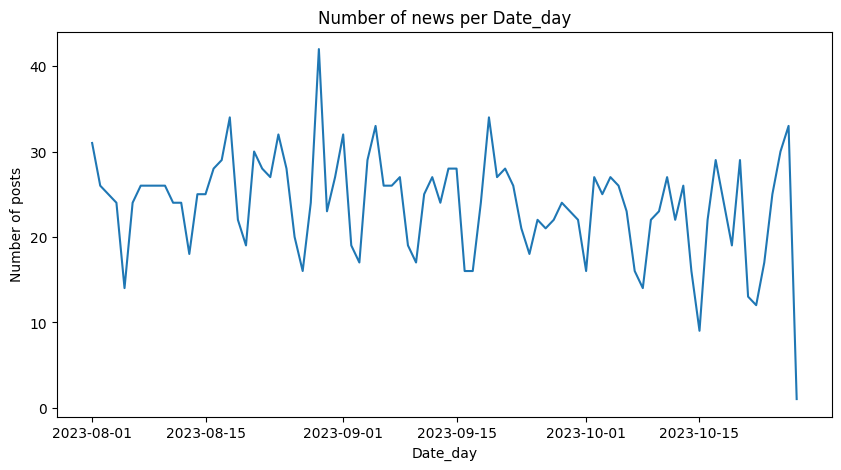

In [11]:
filtered_df["Date_day"] = filtered_df["Date"].apply(lambda x: x.date())
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
filtered_df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

In [12]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def collapse_dots(input):
    input = re.sub("\.+", ".", input)
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
    return input

filtered_df["content_processed"] = filtered_df["content"].apply(process_text)

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_47/3061192408.py:3: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


In [14]:
def read_txt_to_list(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list("/kaggle/input/stopwords/stopwords_ua.txt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


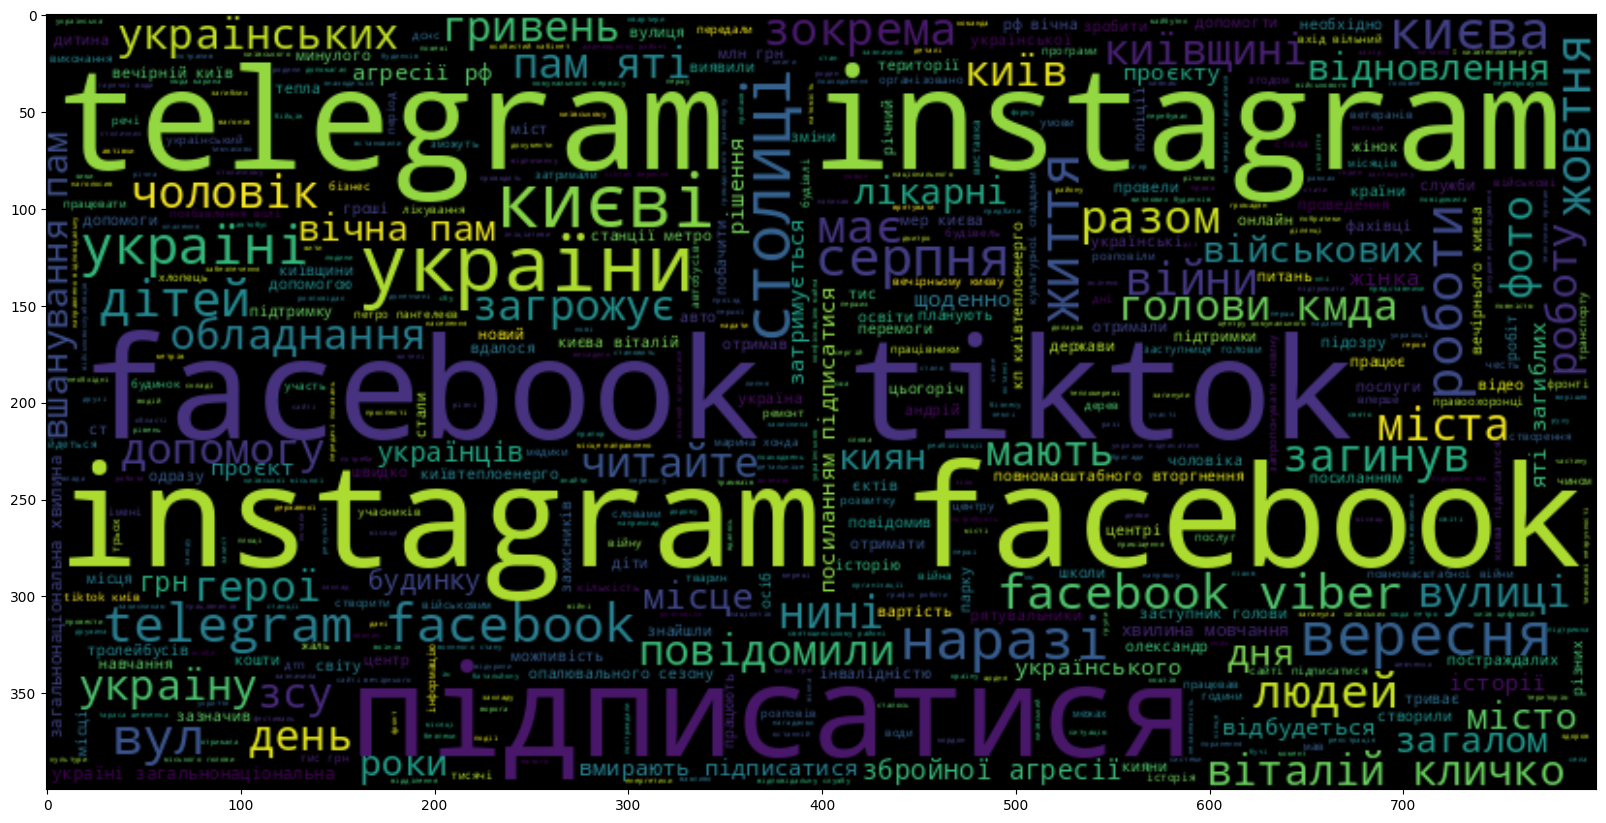

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(filtered_df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')

In [16]:
sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device="cuda",)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

In [17]:
print(torch.cuda.is_available())

True


In [18]:
sent_embeddings = sent_emb_model.encode(filtered_df["content_processed"].to_list(), batch_size=100)

np.save(
   "/kaggle/working/KyivChannels_Dataset_v01_sent_embeddings.npy",
    sent_embeddings
)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [122]:
sent_embeddings = np.load("/kaggle/working/KyivChannels_Dataset_v01_sent_embeddings.npy")
assert sent_embeddings.shape[0] == filtered_df.shape[0]

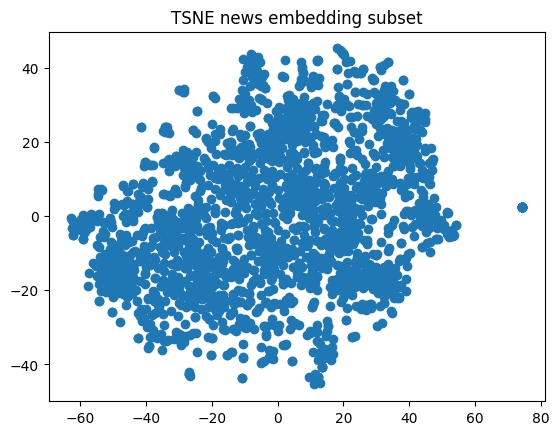

In [125]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(sent_embeddings[:])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

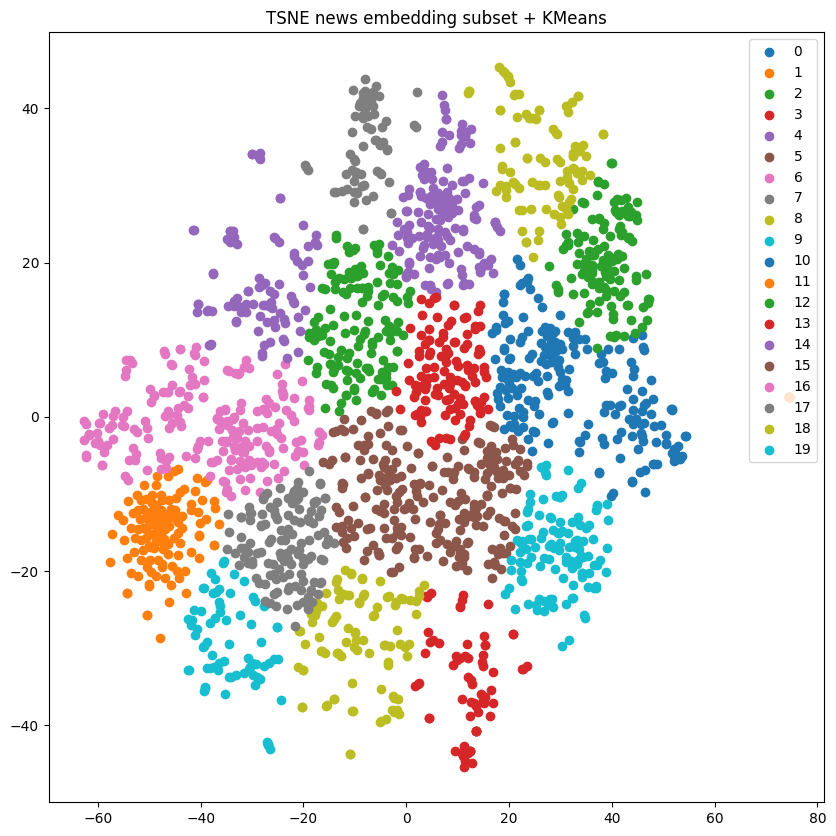

In [126]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=20, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10,10))
plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [24]:
filtered_df.iloc[:][kmeans_clusts_news_embeddings_subset == 8].content.to_list()[:8]

["«Сон літньої ночі» на вечірці👀\n\nСтоличний Театр на Подолі відкриває сезон яскравою прем'єрою. 1 та 2 серпня на сцені театру представлять сучасну інсценізацію знаної комедії Шекспіра у постановці литовської режисерки Андри Каваляускайте. Події оновленого варіанту вистави «Сон літньої ночі» переносять глядача у нічний клуб, а її персонажі спілкуються спеціально розробленою мовою знаків.\n\nПро особливості постановки, їх персонажів та враження від роботи з режисеркою – читайте у матеріалі.\n\n🔷\xa0Підписатися на Telegram\xa0| Instagram\xa0| Facebook\xa0| TikTok",
 "«Сон літньої ночі» на вечірці👀\n\nСтоличний Театр на Подолі відкриває сезон яскравою прем'єрою. 1 та 2 серпня на сцені театру представлять сучасну інсценізацію знаної комедії Шекспіра у постановці литовської режисерки Андри Каваляускайте. Події оновленого варіанту вистави «Сон літньої ночі» переносять глядача у нічний клуб, а її персонажі спілкуються спеціально розробленою мовою знаків.\n\nПро особливості постановки, їх пер

In [25]:
filtered_df.iloc[:][kmeans_clusts_news_embeddings_subset == 7].content.to_list()[:8]

['Попередньо: падіння уламків БПЛА в Соломʼянському районі. Пожежно-рятувальні служби слідують на місце.',
 '📌Куренівський аеродром — аеродром Київського товариства повітроплавання (КТП), існував в Києві з 1909—1910 р. Знаходився на Куренівських (Оболонських) луках, за 1,5-2 км від Кирилівської лікарні, на правому березі Почайни, між Куренівкою і сучасним масивом Оболонь, у районі проспекта С. Бандери та станції метро Почайна.\n\nПочаток аеродрому був покладений у вересні 1910 р., коли пілот Київського товариства повітроплавання Ф. Л. Гейне звернувся до міської Думи з проханням відвести йому в користування землю на Куренівці під аеродром. Перші польоти літаків у Києві відбулись весною 1910 року. Аеродром планувалося використовувати для потреб задуманою у майбутньому повітроплавної школи. \n\nКуренівський аеродром став центральним льотним центром Києва. У 1912—1913 рр. другім подібним центром став Сирецький військовий аеродром, тоді як Куренівський залишився основним цивільним аеродромо

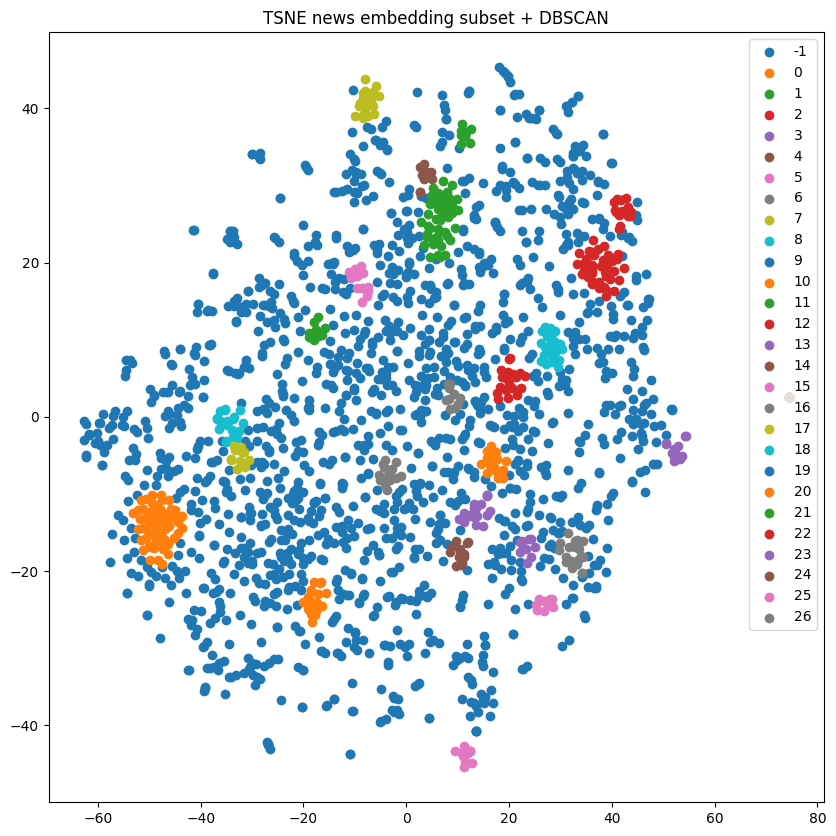

In [147]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=2,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10,10))
plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

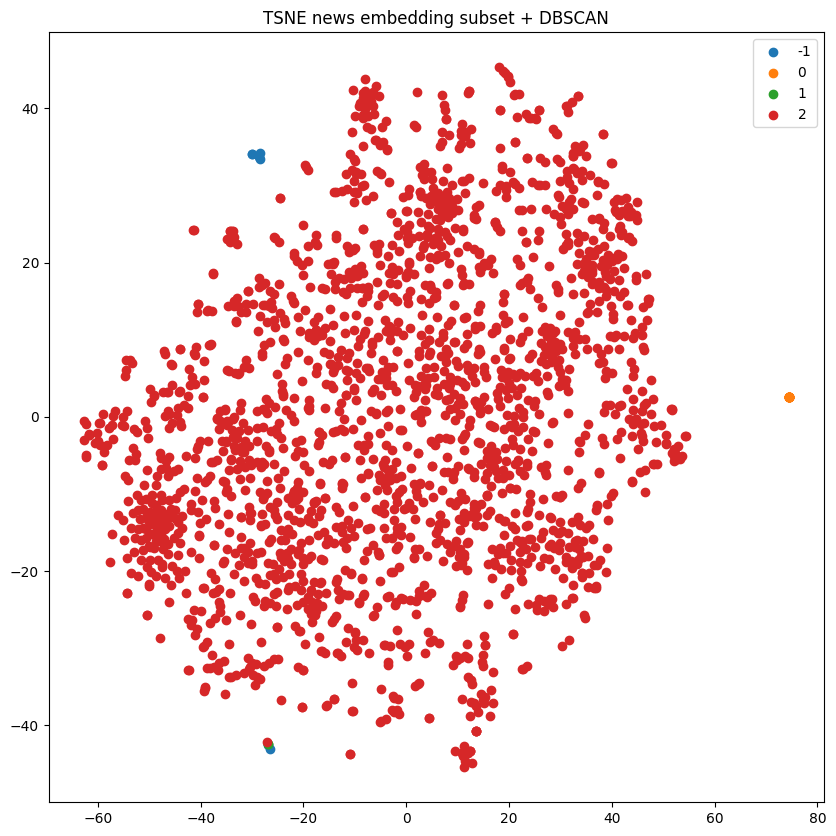

In [148]:
dbscan_clusts_news_embeddings_subset = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10,10))
plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

**HDBSCAN performs worse than DBSCAN, even after adjusting the hyperparameters**

In [27]:
filtered_df.iloc[:][dbscan_clusts_news_embeddings_subset  == 17].content.to_list()[:8]

['📌Бульвар Миколи Міхновського (Дружби Народів).\n\n1990-ті роки\n\n#КПТ_Ретро',
 "На Вишгородщині знайшли унікальний древній предмет ужитку\n\nНа дерев'яні конструкції, вимиті річковими водами, випадково натрапив Юрій, житель села Новосілки Вишгородського району. Розпізнати таємниці дивної знахідки покликав місцевих музейників.\n\nАрхеологи «Вишгородського історико-культурного заповідника» Іван Зоценко та Дмитро Бібіков розчистили конструкцію, що складалася із загострених з одного боку та переплетених між собою плашок, довжиною близько 2 м. Науковці припускають, що на березі знайдено древню пастку для запірного вилову риби (у згорнутому вигляді). \n\nНаразі фахівці провели фіксацію об’єкту, після чого його було законсервовано. Подальша доля  ще вирішується. Більше фото унікальної знахідки є на нашому сайті.\n\n🔷 Підписатися на Telegram | Instagram | Facebook | TikTok",
 'Поезія з фронту📚\n\n14 серпня у київській книгарні «Сенс» відбулася презентація нової книги поетки, бойової медикин

In [28]:
filtered_df.iloc[:][dbscan_clusts_news_embeddings_subset  == 9].content.to_list()[:8]

['ПЦУ канонізувала митрополита Рафаїла Заборовського: чим унікальна його постать\n\nВладика Рафаїл жив у період боротьби Київської митрополії за свої права й автономію, самобутність та традицію, які нищила царська влада. Митрополит робив все для того, щоб повернути давньому першопрестольному місту та Українській Церкві попередні права і привілеї, які відібрали російські монархи.  \nРафаїла вважають одним із найвидатніших українських релігійних діячів XVIII ст. та творцем багатьох сакральних пам’яток у Києві. Його сприймали за святого ще за життя. Та коли той помер, його поховання визнали такими, що «не має наукової цінності». \n\nЧому так сталось та чи дійсно митрополита Рафаїла Заборовського можна вважати святим, читайте на нашому сайті.  \n\n🔷\xa0Підписатися на Telegram\xa0| Instagram\xa0| Facebook\xa0| TikTok',
 'Втрачена святиня Києва\n\nЧи ви знали, що колись неподалік центрального залізничного вокзалу на розі сучасних вулиць Жилянської та Симона Петлюри стояла церква Святого Прор

In [29]:
!python -m spacy download uk_core_news_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 42.6 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for pymorphy3>=1.0.0 from https://files.pythonhosted.org/packages/d7/f9/ffb9afde503dc6bb2361ea79ceaea18138fbcee32aec4c5d8efa49180753/pymorphy3-1.2.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.8 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for docopt-ng>=0.6 from https://files.pythonhosted.org/packages/6c/4a/c3b77fc1a24510b08918b43a473410c0168f6e657118807015f1f1edceea/docopt_ng-0.9.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.8 M

In [30]:
import spacy
from spacy.lang.uk.examples import sentences 

nlp = spacy.load("uk_core_news_sm")

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("uk_core_news_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), 
                                MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2 
}

vectorizer_model = CountVectorizer(min_df=5, stop_words = ua_stopwords + ru_stopwords)

In [32]:
from bertopic import BERTopic
topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
    vectorizer_model = vectorizer_model,
    representation_model = representation_model
)

In [33]:
topics, probs = topic_model.fit_transform(filtered_df.iloc[:]['content_processed'].to_list())

In [34]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs
0,-1,706,-1_київської_київський_києва_українців,"[київської, київський, києва, українців, украї...","[столиці, серпня, роботи, війни, дня, українсь...","[київської, київський, києва, українців, украї...",[Понад 730 млн грн допомоги Київ виплатить діт...
1,0,94,0_києва_київтеплоенерго_київ_житлових,"[києва, київтеплоенерго, київ, житлових, комун...","[сезону, обладнання, будинків, роботи, тепла, ...","[києва, київтеплоенерго, районі, комунального,...",[ℹ️ Київтеплоенерго готує одну з найбільших ко...
2,1,91,1_київської_києва_україні_україни,"[київської, києва, україні, україни, затримали...","[підозру, гривень, доларів, правоохоронці, млн...","[київської, києва, україні, україни, правоохор...",[Переховувався на Київщині й платив гроші доне...
3,2,80,2_україну_україні_україни_загинув,"[україну, україні, україни, загинув, олександр...","[загальнонаціональна, хвилина, мовчання, зброй...","[україні, олександр, командира, загиблого, гер...",[Луганщина вже понад 9 років — місце найгарячі...
4,3,59,3_потребує_київському_військовим_підтримка,"[потребує, київському, військовим, підтримка, ...","[реабілітації, заступниця, підтримки, допомоги...","[потребує, київському, військовослужбовців, пі...",[У Києві пройшла перша зустріч Координаційного...
5,4,57,4_українці_українців_україні_україну,"[українці, українців, україні, україну, україн...","[незалежність, захисників, незалежності, слава...","[українці, українців, україна, незалежності, с...","[Сьогодні, у День пам’яті загиблих Захисників ..."
6,5,52,5_автівки_автомобіль_водіїв_авто,"[автівки, автомобіль, водіїв, авто, києва, киї...","[авто, чоловік, місці, стані, руху, лікарні, п...","[києва, рятувальники, травми, голосіївському, ...",[У Києві рятувальники дістали з понівеченого а...
7,6,49,6_кирилівська_українською_українським_української,"[кирилівська, українською, українським, україн...","[української, життя, нову, українського, сайті...","[кирилівська, українською, українським, україн...",[З 21 по 28 серпня буле змінено маршрути автоб...
8,7,47,7_тварин_тварини_заповіднику_притулок,"[тварин, тварини, заповіднику, притулок, кварт...","[тварин, тварини, науковці, тимчасовий, рятува...","[тварин, заповіднику, квартирі, київській, люд...",[У Ясногородці врятували маленького пацючка🐀. ...
9,8,46,8_затримали_кримінальне_правоохоронці_правоохо...,"[затримали, кримінальне, правоохоронці, правоо...","[чоловік, волі, чоловіка, жінка, поліції, прав...","[затримали, кримінальне, правоохоронці, поліці...",[Чоловік побив об асфальт безпритульного кота....


In [36]:
df_topic = topic_model.get_topic_info()

In [37]:
print(df_topic[df_topic['Topic'] == 39]['Representation'].values[0])

['українською', 'києва', 'український', 'ярослав', 'київ', 'україни', 'україна', 'ukraine', 'tiktok', 'telegram']


In [38]:
print(df_topic[df_topic['Topic'] == 39]['Aspect1'].values[0])

['виконанні', 'новому', 'українською', 'український', 'дітей', '', '', '', '', '']


In [39]:
print(df_topic[df_topic['Topic'] == 39]['Aspect2'].values[0])

['українською', 'києва', 'telegram', 'команда', 'олександра', 'facebook', 'instagram', 'вечірній', 'любов', 'підписатися']


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
categories = [
    'Adult',
    'Art',
    'Blogs',
    'Bookmaking',
    'Books',
    'Business and startups',
    'Career',
    'Courses and guides',
    'Cryptocurrencies',
    'Darknet',
    'Design',
    'Economics',
    'Education',
    'Edutainment',
    'Erotic',
    'Esoterics',
    'Family & Children',
    'Fashion and beauty',
    'Food and cooking',
    'Games',
    'Handiwork',
    'Health and Fitness',
    'Humor and entertainment',
    'Instagram',
    'Interior and construction',
    'Law',
    'Linguistics',
    'Marketing, PR, advertising',
    'Medicine',
    'Music',
    'Nature',
    'News and media',
    'Other',
    'Pictures and photos',
    'Politics',
    'Psychology',
    'Quotes',
    'Religion',
    'Sales',
    'Shock content',
    'Software & Applications',
    'Sport',
    'Technologies',
    'Telegram',
    'Transport',
    'Travel',
    'Video and films'
]

In [80]:
def get_vector(text):
    return nlp(text).vector

first_words = [str(text).split()[0].strip("[]',") for text in df_topic['Aspect1']] 

aspect_vectors = []
max_length = 0

for word in first_words:
    vector = get_vector(word)
    aspect_vectors.append(vector)
    max_length = max(max_length, len(vector))

for i in range(len(aspect_vectors)):
    aspect_vectors[i] = np.pad(aspect_vectors[i], (0, max_length - len(aspect_vectors[i])))

new_matrix = np.zeros((46, 96))
for i, aspect_vector in enumerate(aspect_vectors):
    for j, vector in enumerate(aspect_vector):
        new_matrix[i, j] = vector
aspect_vectors = new_matrix


In [81]:
category_vectors = np.array([get_vector(category) for category in categories])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(aspect_vectors, category_vectors)

# Find the most similar category for each 'Aspect1'
most_similar_category_indices = np.argmax(similarity_matrix, axis=1)
most_similar_categories = [categories[idx] for idx in most_similar_category_indices]

# Add the most similar category to the DataFrame
df_topic['MostSimilarCategory'] = most_similar_categories

In [82]:
df_topic

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs,MostSimilarCategory
0,-1,706,-1_київської_київський_києва_українців,"[київської, київський, києва, українців, украї...","[столиці, серпня, роботи, війни, дня, українсь...","[київської, київський, києва, українців, украї...",[Понад 730 млн грн допомоги Київ виплатить діт...,Psychology
1,0,94,0_києва_київтеплоенерго_київ_житлових,"[києва, київтеплоенерго, київ, житлових, комун...","[сезону, обладнання, будинків, роботи, тепла, ...","[києва, київтеплоенерго, районі, комунального,...",[ℹ️ Київтеплоенерго готує одну з найбільших ко...,Books
2,1,91,1_київської_києва_україні_україни,"[київської, києва, україні, україни, затримали...","[підозру, гривень, доларів, правоохоронці, млн...","[київської, києва, україні, україни, правоохор...",[Переховувався на Київщині й платив гроші доне...,Sales
3,2,80,2_україну_україні_україни_загинув,"[україну, україні, україни, загинув, олександр...","[загальнонаціональна, хвилина, мовчання, зброй...","[україні, олександр, командира, загиблого, гер...",[Луганщина вже понад 9 років — місце найгарячі...,Quotes
4,3,59,3_потребує_київському_військовим_підтримка,"[потребує, київському, військовим, підтримка, ...","[реабілітації, заступниця, підтримки, допомоги...","[потребує, київському, військовослужбовців, пі...",[У Києві пройшла перша зустріч Координаційного...,Psychology
5,4,57,4_українці_українців_україні_україну,"[українці, українців, україні, україну, україн...","[незалежність, захисників, незалежності, слава...","[українці, українців, україна, незалежності, с...","[Сьогодні, у День пам’яті загиблих Захисників ...",Design
6,5,52,5_автівки_автомобіль_водіїв_авто,"[автівки, автомобіль, водіїв, авто, києва, киї...","[авто, чоловік, місці, стані, руху, лікарні, п...","[києва, рятувальники, травми, голосіївському, ...",[У Києві рятувальники дістали з понівеченого а...,Esoterics
7,6,49,6_кирилівська_українською_українським_української,"[кирилівська, українською, українським, україн...","[української, життя, нову, українського, сайті...","[кирилівська, українською, українським, україн...",[З 21 по 28 серпня буле змінено маршрути автоб...,Adult
8,7,47,7_тварин_тварини_заповіднику_притулок,"[тварин, тварини, заповіднику, притулок, кварт...","[тварин, тварини, науковці, тимчасовий, рятува...","[тварин, заповіднику, квартирі, київській, люд...",[У Ясногородці врятували маленького пацючка🐀. ...,Erotic
9,8,46,8_затримали_кримінальне_правоохоронці_правоохо...,"[затримали, кримінальне, правоохоронці, правоо...","[чоловік, волі, чоловіка, жінка, поліції, прав...","[затримали, кримінальне, правоохоронці, поліці...",[Чоловік побив об асфальт безпритульного кота....,Instagram


**So, my topic modeling is really bad in this set. In my opinion, this may be caused by a data handling error**

In [84]:
topic_model.visualize_topics()

In [85]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [86]:
topic_model.visualize_heatmap(n_clusters = 20 )

In [96]:
import warnings
warnings.filterwarnings('ignore')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

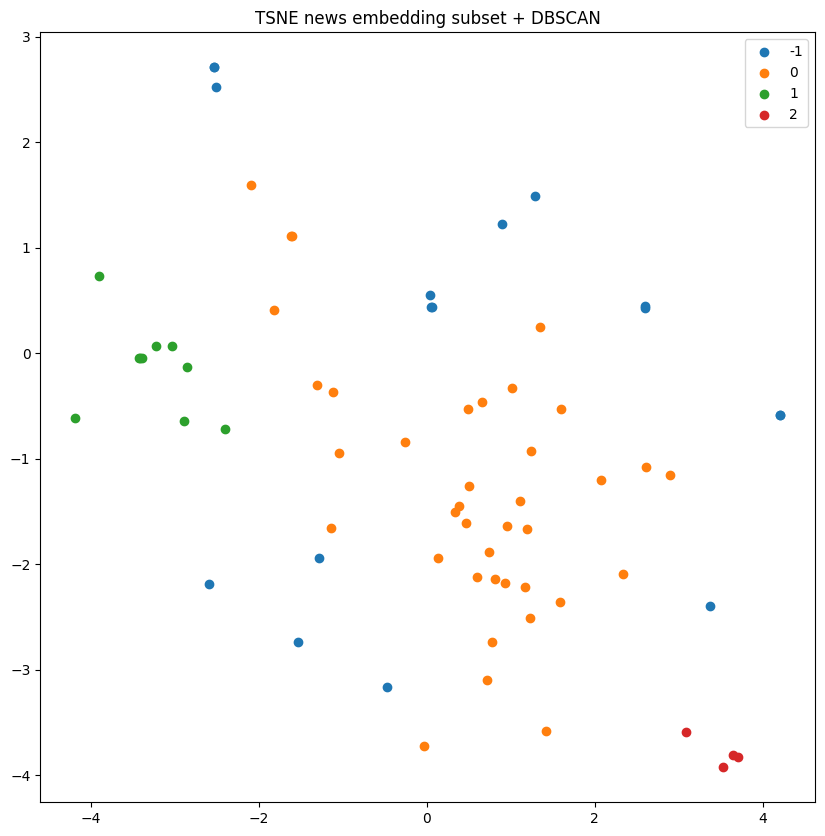

kyivteploenergo:['Books', 'Erotic', 'Esoterics']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

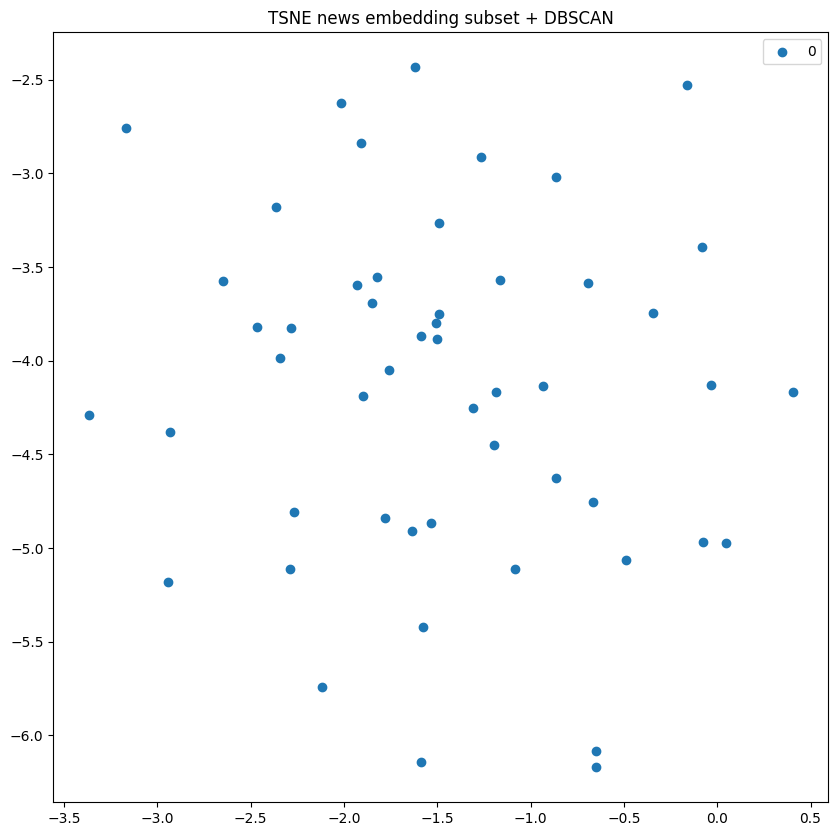

tsum6:['Erotic', 'Adult', 'Adult']


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

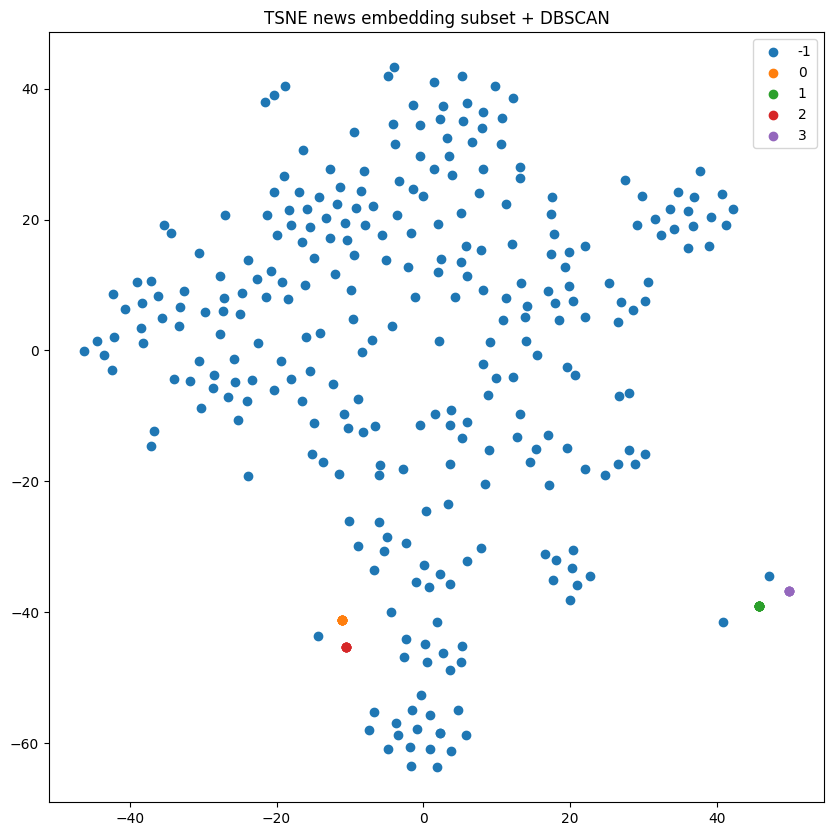

kyivpatrol:['Books', 'Sales', 'Books']


In [103]:
channelnames = ['kyivteploenergo', 'tsum6', 'kyivpatrol']
for name in channelnames:
    df_feo = df[df['channelname'] == name]
    df_feo["lang"] = df_feo["content"].apply(detect_language)
    df_feo["Date_day"] = df_feo["Date"].apply(lambda x: x.date())
    df_feo["content_processed"] = df_feo["content"].apply(process_text)
    sent_embeddings = sent_emb_model.encode(df_feo["content_processed"].to_list(), batch_size=100)
    tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(sent_embeddings[:])
    dbscan_clusts_news_embeddings_subset = DBSCAN(
        eps=1,
        min_samples=4
    ).fit_predict(tsne_news_embeddings_subset)

    plt.figure(figsize=(10,10))
    plt.title("TSNE news embedding subset + DBSCAN")
    for clust in np.unique(dbscan_clusts_news_embeddings_subset):
        plt.scatter(
            tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
            tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
            label=str(clust)
        )
    plt.legend()
    plt.show()
    main_representation_model = KeyBERTInspired()
    aspect_representation_model1 = PartOfSpeech("uk_core_news_sm")
    aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), 
                                    MaximalMarginalRelevance(diversity=.5)]

    representation_model = {
       "Main": main_representation_model,
       "Aspect1":  aspect_representation_model1,
       "Aspect2":  aspect_representation_model2 
    }

    vectorizer_model = CountVectorizer(stop_words = ua_stopwords + ru_stopwords)
    topic_model = BERTopic(
        embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
        vectorizer_model = vectorizer_model,
        representation_model = representation_model
    )
    topics, probs = topic_model.fit_transform(df_feo['content_processed'].to_list())
    df_topic = topic_model.get_topic_info()
    def get_vector(text):
        return nlp(text).vector

    first_words = [str(text).split()[0].strip("[]',") for text in df_topic['Aspect1']] 

    aspect_vectors = []
    max_length = 0

    for word in first_words:
        vector = get_vector(word)
        aspect_vectors.append(vector)
        max_length = max(max_length, len(vector))

    for i in range(len(aspect_vectors)):
        aspect_vectors[i] = np.pad(aspect_vectors[i], (0, max_length - len(aspect_vectors[i])))

    new_matrix = np.zeros((46, 96))
    for i, aspect_vector in enumerate(aspect_vectors):
        for j, vector in enumerate(aspect_vector):
            new_matrix[i, j] = vector
    aspect_vectors = new_matrix
    category_vectors = np.array([get_vector(category) for category in categories])

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(aspect_vectors, category_vectors)

    # Find the most similar category for each 'Aspect1'
    most_similar_category_indices = np.argmax(similarity_matrix, axis=1)
    most_similar_categories = [categories[idx] for idx in most_similar_category_indices]

    # Add the most similar category to the DataFrame
    print(f'{name}:{most_similar_categories[0:3]}')
